In [385]:
import h3
import folium
import numpy as np
from scipy.spatial.distance import euclidean
import networkx as nx
import matplotlib.pyplot as plt

In [386]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_end_of_h3_index = False
        self.h3_indexes = []

class Trie:
    def __init__(self):
        self.root = TrieNode()
        self.graph = nx.DiGraph()

    def insert(self, binary_h3, original_h3):
        node = self.root
        prev_node_name = "root"
        byte_sizes = [1,4,3,4,7,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3]
        node_names = ['Reserved', 'Index Mode', 'Mode-Dependent', 'Resolution', 'Base Cell', 'Res 1 digit', 'Res 2 digit', 'Res 3 digit',
                      'Res 4 digit', 'Res 5 digit', 'Res 6 digit', 'Res 7 digit', 'Res 8 digit', 'Res 9 digit', 'Res 10 digit', 'Res 11 digit',
                      'Res 12 digit', 'Res 13 digit', 'Res 14 digit', 'Res 15 digit']
        start = 0
        for s, name in zip(byte_sizes, node_names):
            bits = binary_h3[start:start+s]
            node_name = name + " - " + bits  # Modified this line to make node names dynamic
            bits = binary_h3[start:start+s]
            if bits not in node.children:
                node.children[bits] = TrieNode()
                self.graph.add_edge(prev_node_name, node_name, label=bits)
            # update
            start = start+s
            node = node.children[bits]
            prev_node_name = node_name

        node.is_end_of_h3_index = True
        node.h3_indexes.append(original_h3)

    def print_trie(self, node=None, indent=""):
        if node is None:
            node = self.root

        if node.is_end_of_h3_index:
            print(indent + "End of H3 Index:", node.h3_indexes)
        
        for bit, child in node.children.items():
            print(indent + str(bit))
            self.print_trie(child, indent + "  ")

    def draw(self, width=10, height=10):
        plt.figure(figsize=(width, height))  # Set the figure size here
        pos = nx.shell_layout(self.graph)
        # pos = nx.circular_layout(self.graph)
        # pos = nx.spring_layout(self.graph, k=0.5)
        nx.draw(self.graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color="skyblue", font_size=10)
        labels = nx.get_edge_attributes(self.graph, 'label')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=labels)
        plt.show()

In [387]:
def hex_to_64bit_binary(hex_string):
    # Convert hex string to integer
    int_val = int(hex_string, 16)

    # Convert integer to binary and remove the "0b" prefix
    bin_string = bin(int_val)[2:]

    # Ensure the binary string is 64 bits long by padding with zeros if necessary
    return bin_string.zfill(64)

In [388]:
def gaussian_probability(distance, sigma=0.01):
    return np.exp(-distance**2 / (2 * sigma**2))


def get_hexagons_around_point(lat, lng, resolution=9, radius=0.03):
    center_hex = h3.geo_to_h3(lat, lng, resolution)
    hexagons = set([center_hex])
    hexagons.update(h3.k_ring(center_hex, 1))
    return hexagons

def visualize_heatmap(points, resolution=9, sigma=0.01, threshold=0.1):
    base_map = folium.Map(location=points[0], zoom_start=14, tiles='cartodb positron')
    all_hexagons = set()

    trie = Trie()

    for lat, lng in points:
        hexagons = get_hexagons_around_point(lat, lng, resolution)
        # hexagons.add(h3.geo_to_h3(lat, lng, resolution-1))
        print(hexagons)
        for h in hexagons:
            trie.insert(hex_to_64bit_binary(h), h)
        trie.print_trie()
        trie.draw(20,20)
        center_hex = h3.geo_to_h3(lat, lng, resolution)

        for index, hexagon in enumerate(hexagons):
            print(f'For the index: {index} the hex index is {hexagon}')
            distance = euclidean(h3.h3_to_geo(center_hex), h3.h3_to_geo(hexagon))
            probability = gaussian_probability(distance, sigma)

            if probability > threshold:
                all_hexagons.add(hexagon)
                color_intensity = int(probability * 255)
                color = f"#{color_intensity:02x}0000"  # Red color with intensity based on probability
                polygon = h3.h3_to_geo_boundary(hexagon)
                folium.Polygon(locations=polygon, color=color, fill=True, fill_color=color, fill_opacity=0.6).add_to(base_map)
                folium.map.Marker(h3.h3_to_geo(hexagon),
                    icon=folium.DivIcon(
                        icon_size=(10,10),
                        icon_anchor=(5,14),
                        html=f'<div style="font-size: 8pt">{index}</div>'
                    )
                ).add_to(base_map)

    return base_map, trie

{'896526acac7ffff', '896526acad3ffff', '896526ace6fffff', '896526acad7ffff', '896526acac3ffff', '896526aca9bffff', '896526aca8bffff'}
0
  0001
    000
      1001
        0110010
          100
            100
              110
                101
                  011
                    001
                      010
                        110
                          001
                            111
                              111
                                111
                                  111
                                    111
                                      111
                                        End of H3 Index: ['896526acac7ffff']
                          100
                            111
                              111
                                111
                                  111
                                    111
                                      111
                                        End of H3 Index: ['896526acad3fff

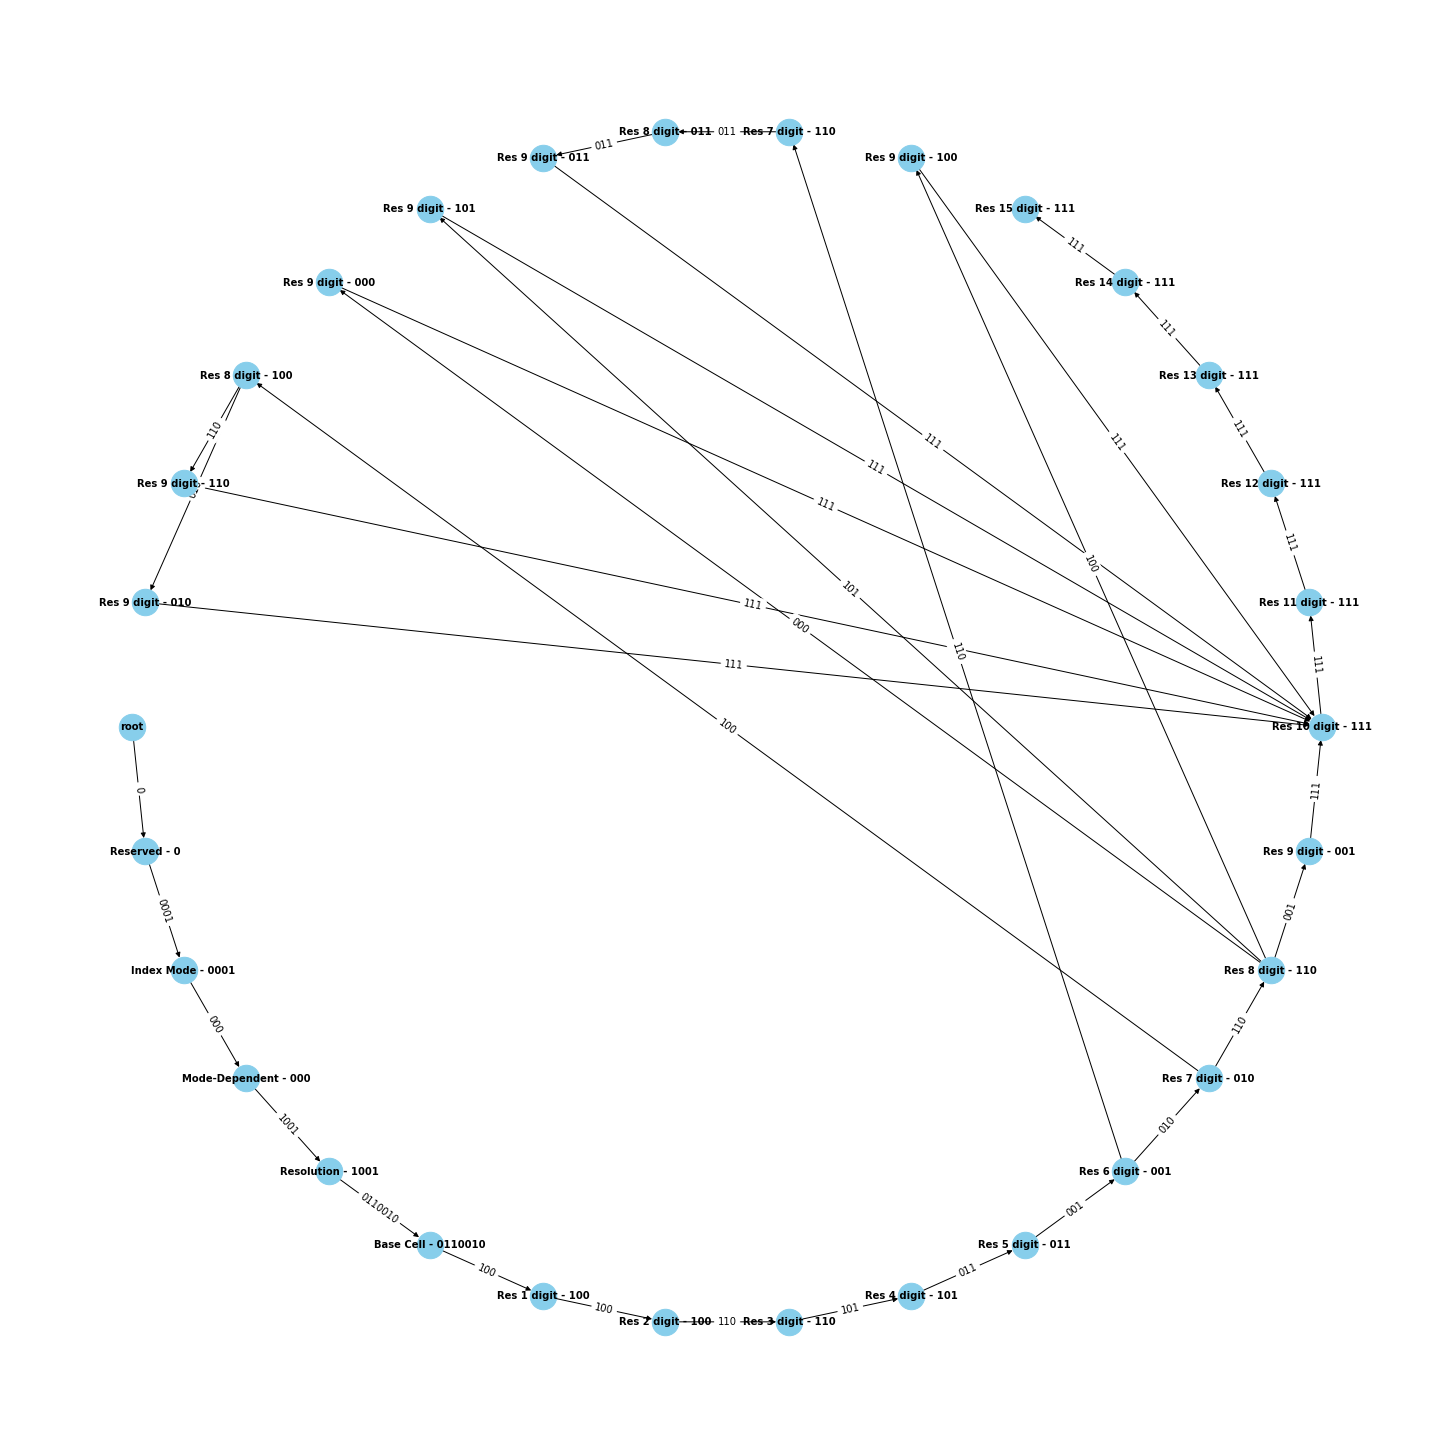

For the index: 0 the hex index is 896526acac7ffff
For the index: 1 the hex index is 896526acad3ffff
For the index: 2 the hex index is 896526ace6fffff
For the index: 3 the hex index is 896526acad7ffff
For the index: 4 the hex index is 896526acac3ffff
For the index: 5 the hex index is 896526aca9bffff
For the index: 6 the hex index is 896526aca8bffff


(<folium.folium.Map at 0x7fdc698d6460>, <__main__.Trie at 0x7fdc691a40d0>)

In [389]:
visualize_heatmap([(1.342098, 103.927395)])

{'896526acac7ffff', '896526acad3ffff', '896526acacbffff', '896526acad7ffff', '896526acac3ffff', '896526acacfffff', '896526acadbffff'}
0
  0001
    000
      1001
        0110010
          100
            100
              110
                101
                  011
                    001
                      010
                        110
                          001
                            111
                              111
                                111
                                  111
                                    111
                                      111
                                        End of H3 Index: ['896526acac7ffff']
                          100
                            111
                              111
                                111
                                  111
                                    111
                                      111
                                        End of H3 Index: ['896526acad3fff

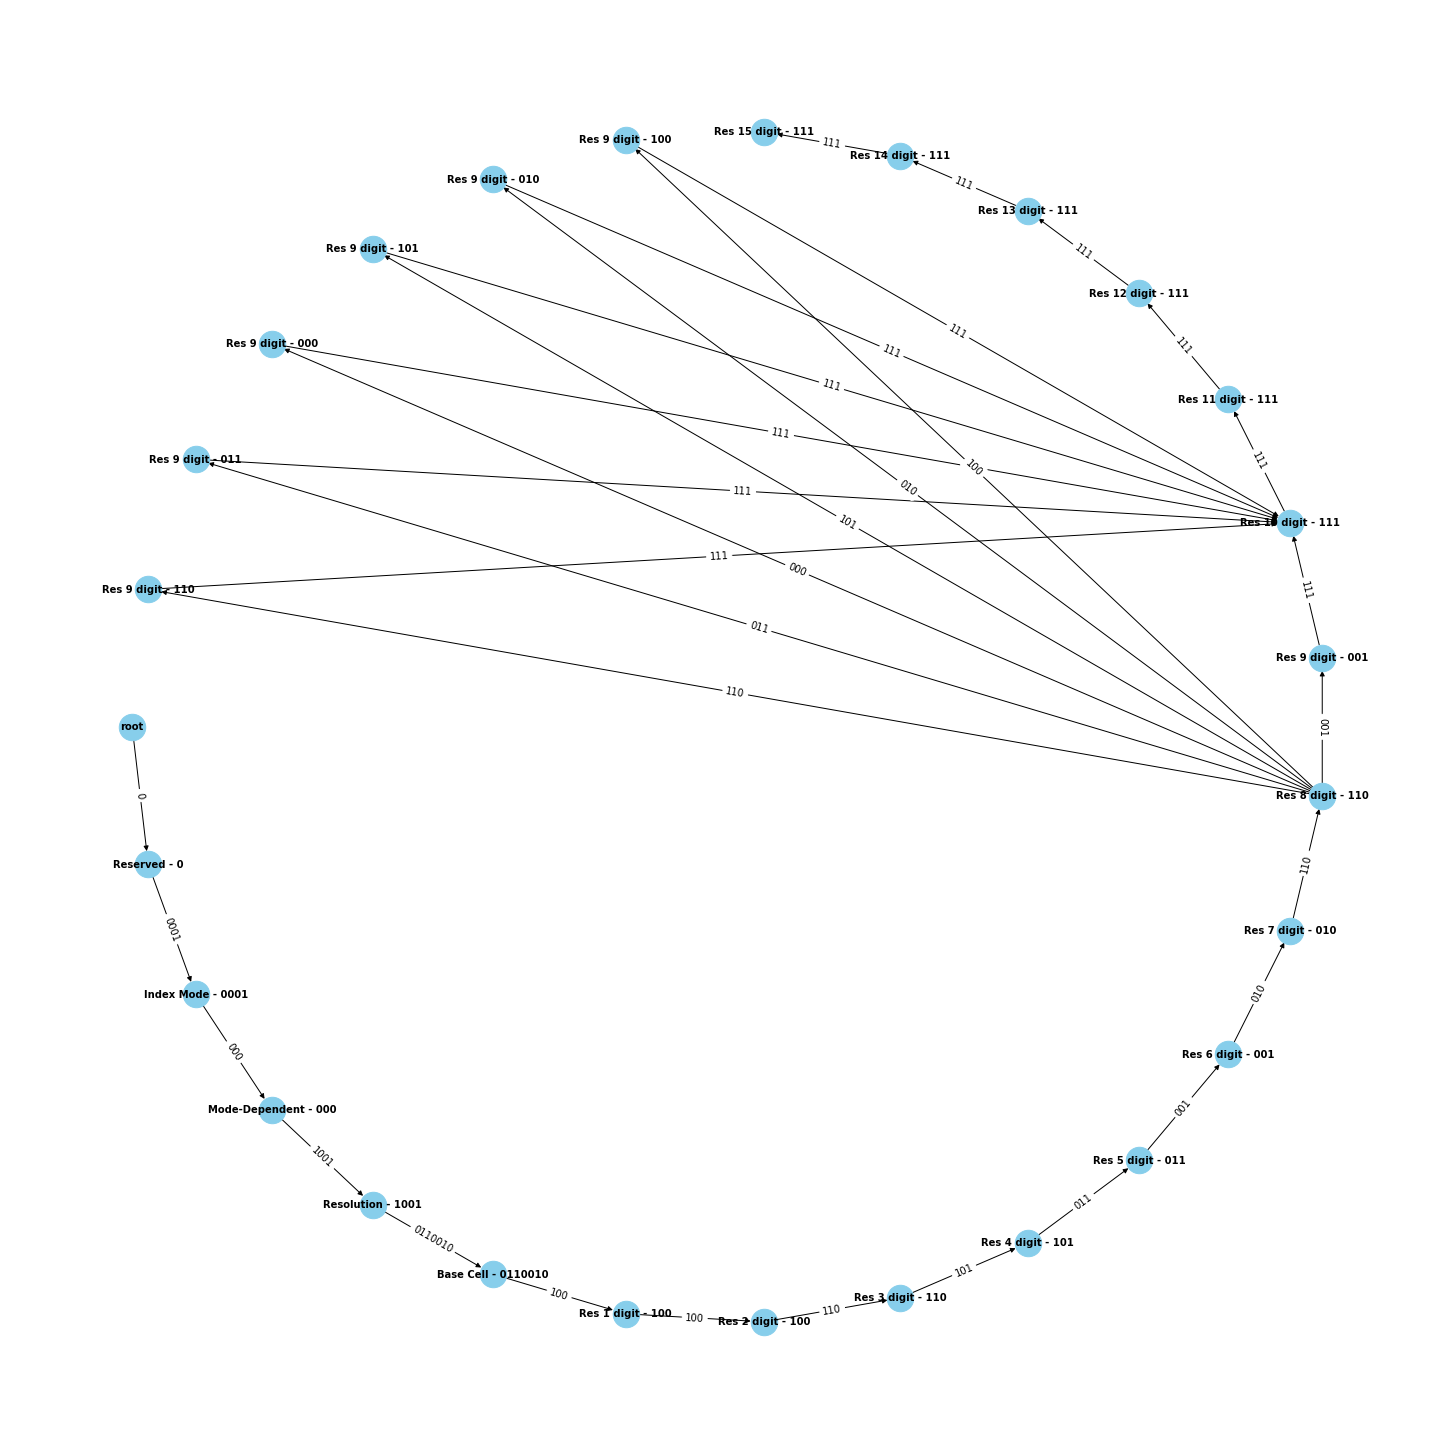

For the index: 0 the hex index is 896526acac7ffff
For the index: 1 the hex index is 896526acad3ffff
For the index: 2 the hex index is 896526acacbffff
For the index: 3 the hex index is 896526acad7ffff
For the index: 4 the hex index is 896526acac3ffff
For the index: 5 the hex index is 896526acacfffff
For the index: 6 the hex index is 896526acadbffff


In [390]:
m, trie = visualize_heatmap([(1.344569, 103.927602)])
